# Feature extraction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import sys
sys.path.insert(0, '..')
from database import mongo_client
from feature_extraction import feature_extraction as fe
%matplotlib inline
from IPython.display import display
from IPython.display import HTML

## Data

In [2]:
client = mongo_client.CERNMongoClient()
data = fe.get_collection(client, "MKI.A5R8.B2:TEMP_TUBE_UP")
display(data.head())

series        MKI.A5R8.B2:TEMP_TUBE_UP
timestep                              
1.467324e+09                      67.4
1.467324e+09                      66.9
1.467325e+09                      66.3
1.467325e+09                      65.8
1.467325e+09                      65.1

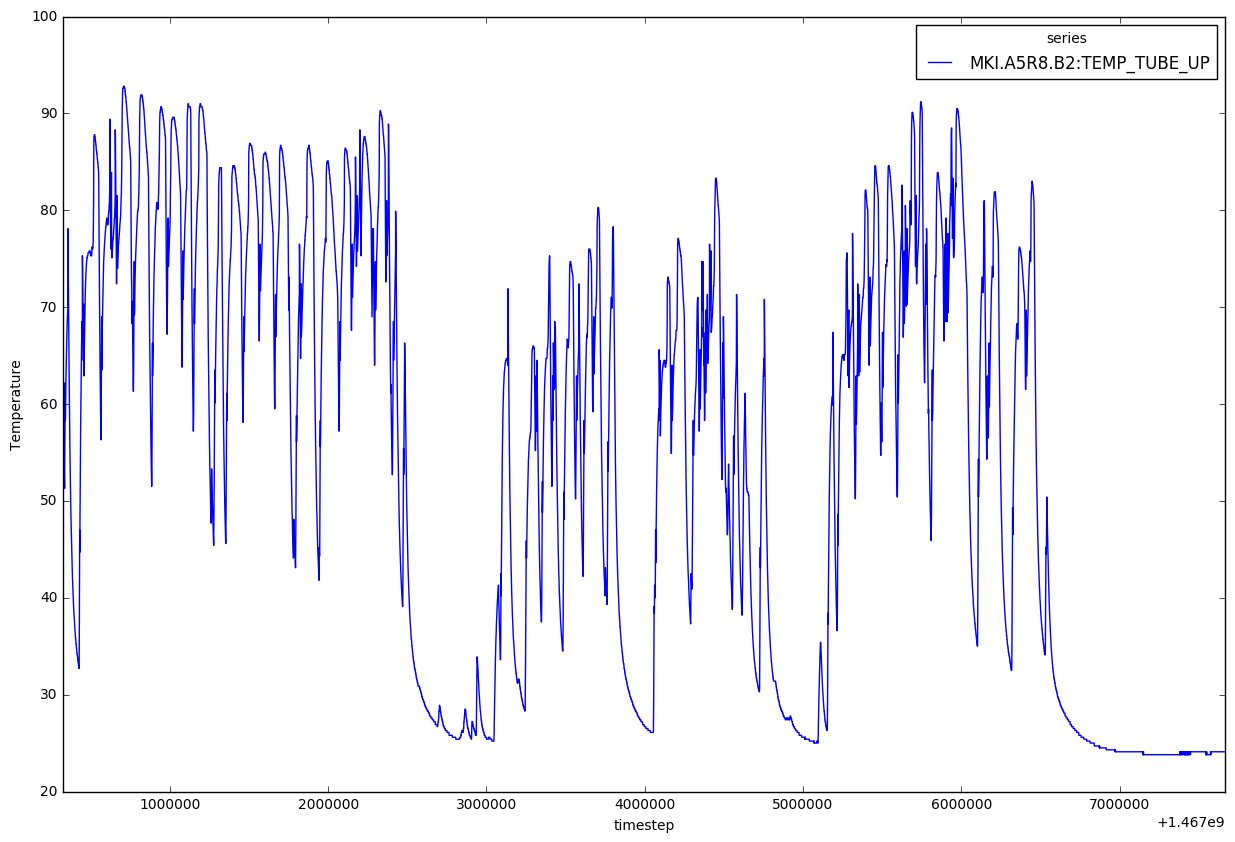

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
data.plot(ax=axes)
axes.set_ylabel("Temperature")

## Feature Extraction

### Simple Features

In [4]:
mean = data.mean()
std = data.std()
display(mean)
display(std)

series
MKI.A5R8.B2:TEMP_TUBE_UP    58.170285
dtype: float64

series
MKI.A5R8.B2:TEMP_TUBE_UP    20.383522
dtype: float64

### Sliding Window Mean

In [5]:
display(fe.get_sampling_frequency(data))
min30 = fe.sliding_window_mean(data, 'T', 30)
day = fe.sliding_window_mean(data, 'D', 1)
day10 = fe.sliding_window_mean(data, 'D', 10)

timestep    581.047131
dtype: float64

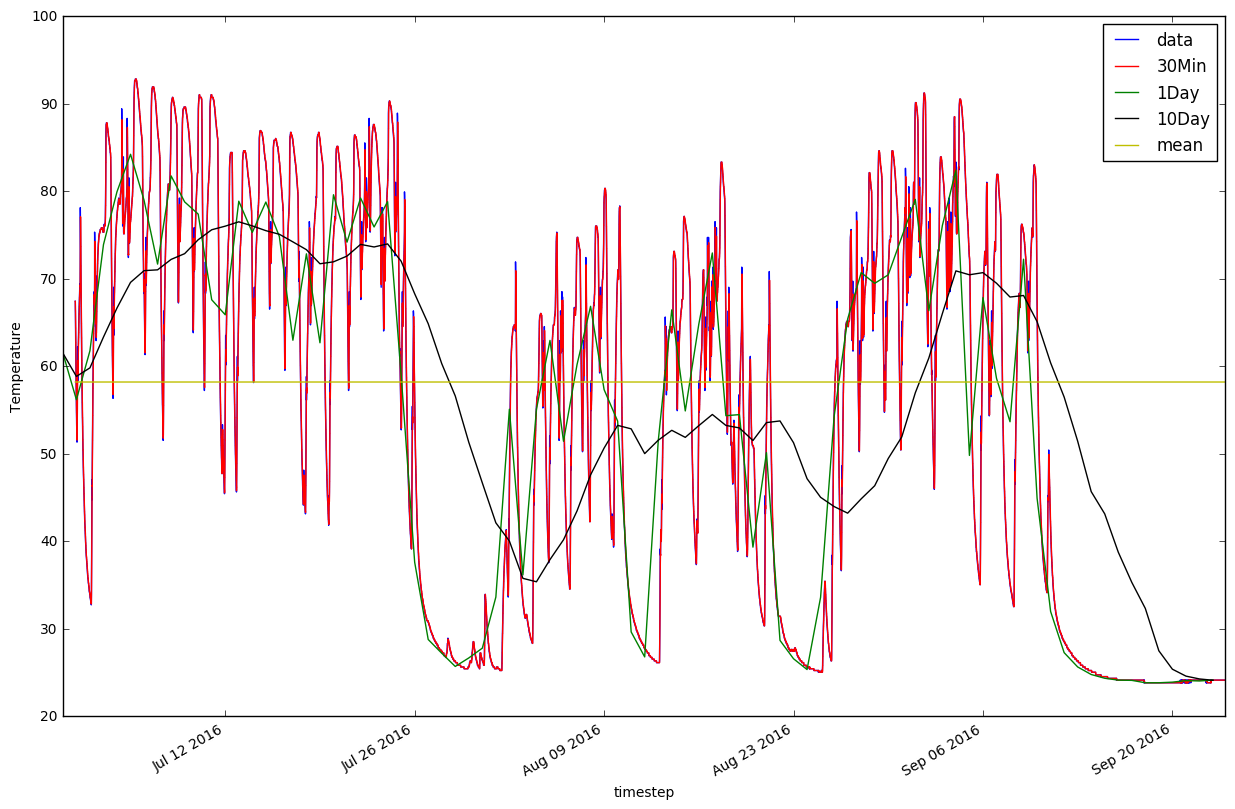

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
data.plot(ax=axes, color='b')
min30.plot(ax=axes, color='r')
day.plot(ax=axes, color='g')
day10.plot(ax=axes, color='k')
pd.Series(mean[0], index = data.index).plot(ax=axes, color='y')
labels = ["data", "30Min", "1Day", "10Day", "mean"]
axes.legend(labels)
axes.set_ylabel("Temperature")

### Zero-Crossing Rate (ZCR)

The zero crossing rate is the (relative) number of times 2 consecutive values differ in sign. The data is first centered around 0 by subtracting the mean. The ZCR is low here because the sampling frequency is very high.

In [7]:
data_shift = data - mean
zcr = data_shift.apply(lambda x: (np.diff(np.signbit(x)) != 0).sum()/float(x.count()))
display(zcr)

series
MKI.A5R8.B2:TEMP_TUBE_UP    0.007674
dtype: float64

### Peak Finding

array([   48,    77,    94,   278,   298,   327,   404,   534,   587,
         621,   659,   712,   757,   908,   947,  1150,  1320,  1478,
        1638,  1875,  2040,  2217,  2374,  2536,  2667,  2770,  2813,
        2847,  2896,  3115,  3255,  3391,  3433,  3466,  3506,  3642,
        3705,  3833,  3860,  3877,  3928,  3972,  4008,  4148,  4960,
        5244,  5421,  5483,  5506,  5527,  5698,  5808,  5845,  5960,
        6043,  6285,  6689,  6704,  6719,  6858,  7165,  7192,  7208,
        7226,  7246,  7273,  7299,  7320,  7359,  7383,  7537,  7562,
        7728,  7835,  8024,  8041,  8608,  8780,  8814,  8868,  8939,
        8974,  9006,  9133,  9268,  9296,  9335,  9478,  9541,  9585,
        9610,  9623,  9656,  9698,  9702,  9783,  9929,  9955,  9990,
       10047, 10183, 10218, 10253, 10293, 10344, 10377, 10675, 10737,
       10766, 11154])

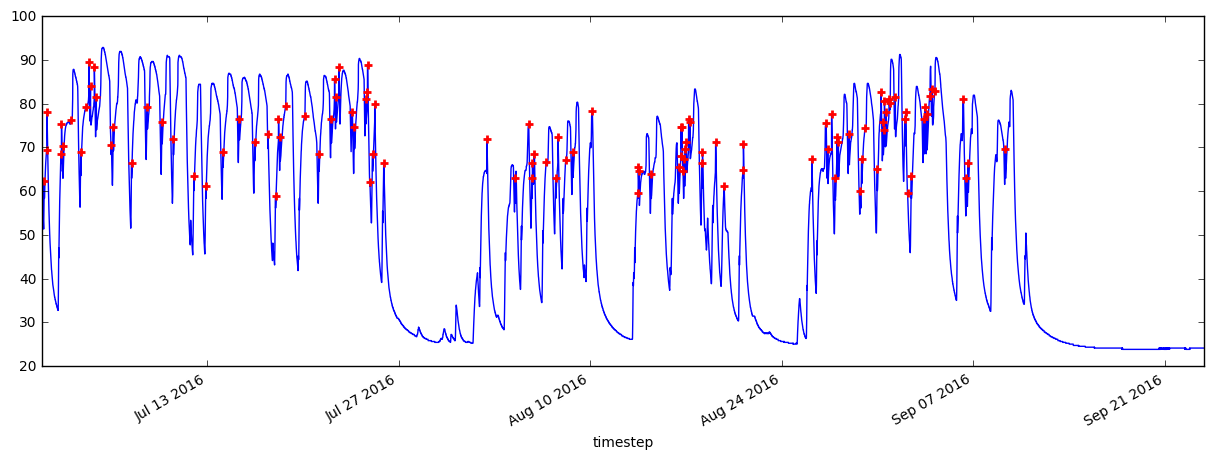

In [8]:
peak_indices = peakutils.indexes(data["MKI.A5R8.B2:TEMP_TUBE_UP"].transpose().values, thres=0.50)
display(peak_indices)
fig, axes = plt.subplots(figsize=(15,5), nrows=1,ncols=1)
data["MKI.A5R8.B2:TEMP_TUBE_UP"].plot(ax=axes,legend=False)
data["MKI.A5R8.B2:TEMP_TUBE_UP"].iloc[peak_indices].to_frame().plot(marker='+',markeredgewidth=2,color='red',ax=axes,legend=False,linestyle='')

### Wavelet Transform

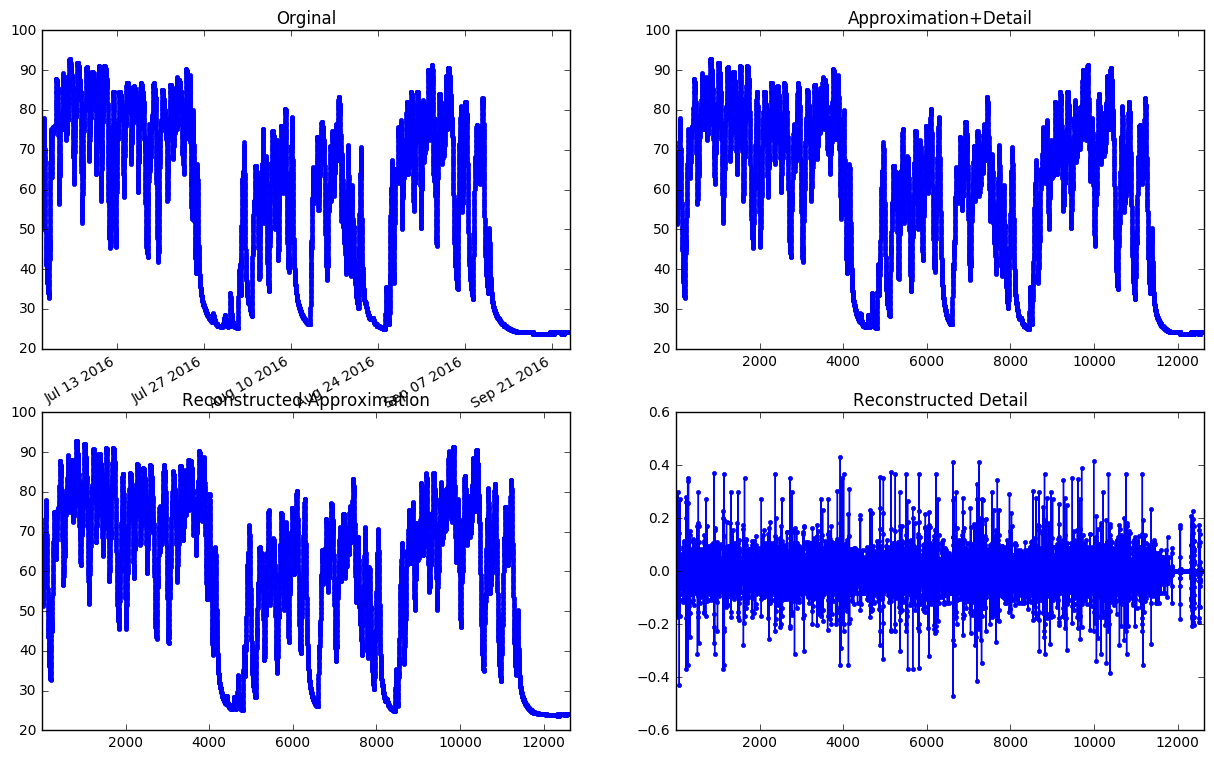

In [9]:
l1, cA1, cD1 = fe.wavelet_transform(data)
fe.plot_wavelet(data, "MKI.A5R8.B2:TEMP_TUBE_UP", cA1, cD1)